In [1]:
import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity

from qiskit.visualization import plot_histogram

In [2]:
import qiskit.tools.jupyter
%qiskit_version_table

## 使用numpy求解线性方程组

In [3]:
a = np.array([[1,1],[1/np.sqrt(2),-1/np.sqrt(2)]])
b = np.array([[1/2],[-1/np.sqrt(2)]])
x = np.linalg.solve(a, b)

print(a,'\n', b)
print(x)
print(np.allclose(np.dot(a, x), b))

[[ 1.          1.        ]
 [ 0.70710678 -0.70710678]] 
 [[ 0.5       ]
 [-0.70710678]]
[[-0.25]
 [ 0.75]]
True


## 使用sympy

In [5]:
import sympy as sp

sp.init_printing(use_unicode=True)

## 将 A变成Hermitian矩阵

In [8]:
B_sp = sp.Matrix([[sp.sqrt(2)/4],[-sp.sqrt(2)/2]])

A_sp = sp.Matrix([[1,1],[1,-1]])/sp.sqrt(2)

A_sp, B_sp

⎛⎡√2   √2 ⎤  ⎡ √2 ⎤⎞
⎜⎢──   ── ⎥  ⎢ ── ⎥⎟
⎜⎢2    2  ⎥  ⎢ 4  ⎥⎟
⎜⎢        ⎥, ⎢    ⎥⎟
⎜⎢√2  -√2 ⎥  ⎢-√2 ⎥⎟
⎜⎢──  ────⎥  ⎢────⎥⎟
⎝⎣2    2  ⎦  ⎣ 2  ⎦⎠

In [10]:
P,D = A_sp.diagonalize()

P,D 

⎛⎡1 - √2  1 + √2⎤  ⎡-1  0⎤⎞
⎜⎢              ⎥, ⎢     ⎥⎟
⎝⎣  1       1   ⎦  ⎣0   1⎦⎠

## 归一化的特征向量矩阵

In [17]:
# normalize the eigenvectors  第1列，第2列
# P_Asp_new[:,0] = P_Asp_new[:,0]/ P_Asp_new[:,0].norm()
# P_Asp_new[:,1] = P_Asp_new[:,1]/ P_Asp_new[:,1].norm()

# P_normal 和 P 形状一样
P_normal = P.copy() # 用copy()，不然会改变P的值



P_normal[:,0] = P[:,0]/ P[:,0].norm()
P_normal[:,1] = P[:,1]/ P[:,1].norm()

P_normal, P_normal.evalf()


⎛⎡       1 - √2              1 + √2      ⎤                                    
⎜⎢───────────────────  ──────────────────⎥                                    
⎜⎢   ________________     _______________⎥                                    
⎜⎢  ╱          2         ╱             2 ⎥                                    
⎜⎢╲╱  (-1 + √2)  + 1   ╲╱  1 + (1 + √2)  ⎥  ⎡-0.38268343236509  0.923879532511
⎜⎢                                       ⎥, ⎢                                 
⎜⎢         1                   1         ⎥  ⎣0.923879532511287  0.382683432365
⎜⎢───────────────────  ──────────────────⎥                                    
⎜⎢   ________________     _______________⎥                                    
⎜⎢  ╱          2         ╱             2 ⎥                                    
⎝⎣╲╱  (-1 + √2)  + 1   ╲╱  1 + (1 + √2)  ⎦                                    

    ⎞
    ⎟
    ⎟
    ⎟
287⎤⎟
   ⎥⎟
09 ⎦⎟
    ⎟
    ⎟
    ⎟
    ⎠

## 增加辅助矩阵，方便计算，得到最后的A矩阵对角元为1和2，便于后面受控旋转门的简化

In [19]:
# M_ancilla make A become eigenvalues are 1 and 2
M_ancilla = P_normal * sp.Matrix([[-1,0],[0,2]]) * P_normal.inv()

M_ancilla, M_ancilla.evalf()

⎛⎡                                                                            
⎜⎢                                                                            
⎜⎢                                                ________                    
⎜⎢         (-2 + √2)⋅(1 - √2)          (1 + √2)⋅╲╱ √2 + 2               √2⋅(1 
⎜⎢- ──────────────────────────────── + ───────────────────  - ────────────────
⎜⎢                  ________________       _______________                    
⎜⎢      ________   ╱          2           ╱             2         ________   ╱
⎜⎢  2⋅╲╱ 2 - √2 ⋅╲╱  (-1 + √2)  + 1     ╲╱  1 + (1 + √2)      2⋅╲╱ 2 - √2 ⋅╲╱ 
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                                                            
⎜⎢                                           ________                         
⎜⎢              -2 + √2                    ╲╱ √2 + 2

In [20]:
# M_ancilla * A_sp
P_new, D_new = (M_ancilla * A_sp).diagonalize()

P_new, D_new

⎛⎡1 - √2  1 + √2⎤  ⎡1  0⎤⎞
⎜⎢              ⎥, ⎢    ⎥⎟
⎝⎣  1       1   ⎦  ⎣0  2⎦⎠

In [24]:
# B_new = M_ancilla * B_sp
B_new = M_ancilla * B_sp

B_new.evalf()

⎡-0.198223304703363⎤
⎢                  ⎥
⎣0.771446609406726 ⎦

## 生成归一化 的 $|b\rangle$ 的状态向量

In [23]:
# 归一化
B_new_normal = B_new / B_new.norm()

B_new_normal.evalf()

⎡-0.248865947128923⎤
⎢                  ⎥
⎣0.968537939556125 ⎦

##  求 $\theta_{b}$
$\theta_{b}$ 用于b的旋转角度，初态制备，$|b\rangle= R_y(\theta) |0\rangle$

In [25]:

theta_bneg = sp.asin(- B_new_normal.evalf()[1])  # theta_bneg is beyond the range of [-pi/2,pi/2]

#  theta_b = pi - theta_bneg
theta_b = 2* (2*sp.pi + theta_bneg)- 2 * sp.pi

theta_b.evalf()

## 求 $Udiag$

In [26]:
U_diag = sp.Matrix([[sp.I,0],[0,-1]])

U_diag

⎡ⅈ  0 ⎤
⎢     ⎥
⎣0  -1⎦

## 求 $U$

In [28]:
U = P_normal * U_diag * P_normal.inv()

U.evalf()

⎡-0.853553390593274 + 0.146446609406726⋅ⅈ  -0.353553390593274 - 0.353553390593
⎢                                                                             
⎣-0.353553390593274 - 0.353553390593274⋅ⅈ  -0.146446609406726 + 0.853553390593

274⋅ⅈ⎤
     ⎥
274⋅ⅈ⎦

## 验证 U的幺正性

In [69]:
# U的共轭转置
U_dag = U.conjugate().transpose()


(U * U_dag).evalf(), U_dag.evalf()

⎛⎡        1.0          0.e-126 + 0.e-125⋅ⅈ⎤  ⎡-0.853553390593274 - 0.146446609
⎜⎢                                        ⎥, ⎢                                
⎝⎣0.e-126 + 0.e-125⋅ⅈ          1.0        ⎦  ⎣-0.353553390593274 + 0.353553390

406726⋅ⅈ  -0.353553390593274 + 0.353553390593274⋅ⅈ⎤⎞
                                                  ⎥⎟
593274⋅ⅈ  -0.146446609406726 - 0.853553390593274⋅ⅈ⎦⎠

## 求U的四个角度参数中的第一个参数 $\theta$，得到$\theta/2=\pi/6$

In [42]:
# −0.853553390593274+0.146446609406726i 的绝对值
abs(-0.853553390593274+0.146446609406726j)


np.arccos(abs(-0.853553390593274+0.146446609406726j)),sp.pi/6
# 实际是 pi/6


In [36]:
np.sin(np.arccos(abs(-0.853553390593274+0.146446609406726j))), sp.sin(sp.pi/6)

## 求解 $\gamma+\lambda$

In [46]:
# −0.353553390593274−0.353553390593274i
# np.angle(-0.353553390593274-0.353553390593274j)+ np.pi

## 求解 $\gamma$

In [47]:
# 求复数-0.853553390593274+0.146446609406726j的辐角
np.angle(-0.853553390593274+0.146446609406726j)



## 试图用分数近似 $\gamma$

In [57]:
# 将一个复数近似为一个分数
2.97167419886273/np.pi

# 小数近似转分数
from fractions import Fraction
Fraction(2.97167419886273/np.pi).limit_denominator(100)


Fraction(35, 37)

## 验证 U ，使用四个参数

In [67]:
# use U to get quantum circuit unitary gate cu 4 parameters theta,phi,lambda,gamma
theta = sp.symbols('theta')
phi = sp.symbols('phi')
lambda_ = sp.symbols('lambda_')
gamma = sp.symbols('gamma')
U_angles = sp.Matrix([[sp.exp(sp.I*gamma)*sp.cos(theta/2),-sp.exp(sp.I*(gamma+lambda_))*sp.sin(theta/2)],[sp.exp(sp.I*(gamma+phi))*sp.sin(theta/2),sp.exp(sp.I*(lambda_+gamma+phi))*sp.cos(theta/2)]])
display(U_angles.evalf())
# use codes to solve the  equation U_angles = U, get the angles theta,phi,lambda,gamma 
#  theta_U = pi/2
#  phi_U = 0
#  lambda_U = pi
#  gamma_U = pi/2
gamma_U = 2.97167419886273
theta_U = sp.pi/3
phi_U = sp.pi + sp.pi/4 - gamma_U
lambda_U = sp.pi/4 - gamma_U

print('theta_U = ',theta_U.evalf())
print('phi_U = ',phi_U.evalf())
print('lambda_U = ',lambda_U.evalf())
print('gamma_U = ',gamma_U)

print([theta_U,phi_U,lambda_U,gamma_U])



U_angles = U_angles.subs([(theta,theta_U),(phi,phi_U),(lambda_,lambda_U),(gamma,gamma_U)])
print('U_angles:\n')
display(U_angles.evalf())

⎡    ⅈ⋅γ    ⎛θ⎞        ⅈ⋅(γ + λ)    ⎛θ⎞  ⎤
⎢   ℯ   ⋅cos⎜─⎟      -ℯ         ⋅sin⎜─⎟  ⎥
⎢           ⎝2⎠                     ⎝2⎠  ⎥
⎢                                        ⎥
⎢ ⅈ⋅(γ + φ)    ⎛θ⎞   ⅈ⋅(γ + λ + φ)    ⎛θ⎞⎥
⎢ℯ         ⋅sin⎜─⎟  ℯ             ⋅cos⎜─⎟⎥
⎣              ⎝2⎠                    ⎝2⎠⎦

theta_U =  1.04719755119660
phi_U =  0.955316618124512
lambda_U =  -2.18627603546528
gamma_U =  2.97167419886273
[pi/3, -2.97167419886273 + 5*pi/4, -2.97167419886273 + pi/4, 2.97167419886273]
U_angles:



⎡-0.853553390593273 + 0.146446609406728⋅ⅈ  -0.353553390593274 - 0.353553390593
⎢                                                                             
⎣-0.353553390593274 - 0.353553390593274⋅ⅈ  -0.146446609406728 + 0.853553390593

274⋅ⅈ⎤
     ⎥
273⋅ⅈ⎦

## 求解 $U^2$
发现 $U^2$就是Hadamard门

In [50]:
(U * U).evalf() # U的平方 is H gate

⎡0.707106781186548 + 0.e-21⋅ⅈ  0.707106781186548 + 0.e-21⋅ⅈ ⎤
⎢                                                           ⎥
⎣0.707106781186548 + 0.e-21⋅ⅈ  -0.707106781186548 + 0.e-21⋅ⅈ⎦

## 使用四个参数验证 $U^2$

In [68]:
# use U to get quantum circuit unitary gate cu 4 parameters theta,phi,lambda,gamma
theta = sp.symbols('theta')
phi = sp.symbols('phi')
lambda_ = sp.symbols('lambda_')
gamma = sp.symbols('gamma')
U_angles = sp.Matrix([[sp.exp(sp.I*gamma)*sp.cos(theta/2),-sp.exp(sp.I*(gamma+lambda_))*sp.sin(theta/2)],[sp.exp(sp.I*(gamma+phi))*sp.sin(theta/2),sp.exp(sp.I*(lambda_+gamma+phi))*sp.cos(theta/2)]])
display(U_angles.evalf())

# theta_U2 = 0
# phi_U2 = 0
# lambda_U2 = 0
# gamma_U2 = pi
theta_U2 = np.pi/2
phi_U2 = 0
lambda_U2 = np.pi
gamma_U2 = 0

print('theta_U2 = ',theta_U2)
print('phi_U2 = ',phi_U2)
print('lambda_U2 = ',lambda_U2)
print('gamma_U2 = ',gamma_U2)

print([theta_U2,phi_U2,lambda_U2,gamma_U2])

U_angles2 = U_angles.subs([(theta,theta_U2),(phi,phi_U2),(lambda_,lambda_U2),(gamma,gamma_U2)])
print('U_angles2:\n')
display(U_angles2.evalf())

⎡    ⅈ⋅γ    ⎛θ⎞        ⅈ⋅(γ + λ)    ⎛θ⎞  ⎤
⎢   ℯ   ⋅cos⎜─⎟      -ℯ         ⋅sin⎜─⎟  ⎥
⎢           ⎝2⎠                     ⎝2⎠  ⎥
⎢                                        ⎥
⎢ ⅈ⋅(γ + φ)    ⎛θ⎞   ⅈ⋅(γ + λ + φ)    ⎛θ⎞⎥
⎢ℯ         ⋅sin⎜─⎟  ℯ             ⋅cos⎜─⎟⎥
⎣              ⎝2⎠                    ⎝2⎠⎦

theta_U2 =  1.5707963267948966
phi_U2 =  0
lambda_U2 =  3.141592653589793
gamma_U2 =  0
[1.5707963267948966, 0, 3.141592653589793, 0]
U_angles2:



⎡0.707106781186548  0.707106781186547 - 8.65956056235493e-17⋅ⅈ ⎤
⎢                                                              ⎥
⎣0.707106781186547  -0.707106781186548 + 8.65956056235493e-17⋅ⅈ⎦

## $U^{\dagger}$的四个参数求解
$\theta$ 不变，依旧是$\pi/3$

In [71]:
U_dag.evalf()

⎡-0.853553390593274 - 0.146446609406726⋅ⅈ  -0.353553390593274 + 0.353553390593
⎢                                                                             
⎣-0.353553390593274 + 0.353553390593274⋅ⅈ  -0.146446609406726 - 0.853553390593

274⋅ⅈ⎤
     ⎥
274⋅ⅈ⎦

In [74]:
# gamma_Udag = 2pi - gamma_U
gamma_Udag = 2*sp.pi - gamma_U
gamma_Udag


In [75]:
# phi_Udag = pi-pi/4- gamma_Udag
phi_Udag = sp.pi - sp.pi/4 - gamma_Udag

# lambda_Udag = 2*sp.pi - sp.pi/4 - gamma_Udag
lambda_Udag = 2*sp.pi - sp.pi/4 - gamma_Udag

phi_Udag, lambda_Udag

In [76]:
# use U_dag to get quantum circuit unitary gate cu 4 parameters theta,phi,lambda,gamma
theta = sp.symbols('theta')
phi = sp.symbols('phi')
lambda_ = sp.symbols('lambda_')
gamma = sp.symbols('gamma')

U_angles_dag = sp.Matrix([[sp.exp(sp.I*gamma)*sp.cos(theta/2),-sp.exp(sp.I*(gamma+lambda_))*sp.sin(theta/2)],[sp.exp(sp.I*(gamma+phi))*sp.sin(theta/2),sp.exp(sp.I*(lambda_+gamma+phi))*sp.cos(theta/2)]])
display(U_angles_dag.evalf())

# theta_Udag = pi/3
# phi_Udag = pi-pi/4- gamma_Udag
# lambda_Udag = 2*sp.pi - sp.pi/4 - gamma_Udag
# gamma_Udag = 2pi - gamma_U
theta_Udag = sp.pi/3
gamma_Udag = 2*sp.pi - gamma_U
phi_Udag = sp.pi - sp.pi/4 - gamma_Udag
lambda_Udag = 2*sp.pi - sp.pi/4 - gamma_Udag

print('theta_Udag = ',theta_Udag)
print('phi_Udag = ',phi_Udag)
print('lambda_Udag = ',lambda_Udag)
print('gamma_Udag = ',gamma_Udag)

print([theta_Udag,phi_Udag,lambda_Udag,gamma_Udag])

U_angles_dag = U_angles_dag.subs([(theta,theta_Udag),(phi,phi_Udag),(lambda_,lambda_Udag),(gamma,gamma_Udag)])
print('U_angles_dag:\n')
display(U_angles_dag.evalf())


⎡    ⅈ⋅γ    ⎛θ⎞        ⅈ⋅(γ + λ)    ⎛θ⎞  ⎤
⎢   ℯ   ⋅cos⎜─⎟      -ℯ         ⋅sin⎜─⎟  ⎥
⎢           ⎝2⎠                     ⎝2⎠  ⎥
⎢                                        ⎥
⎢ ⅈ⋅(γ + φ)    ⎛θ⎞   ⅈ⋅(γ + λ + φ)    ⎛θ⎞⎥
⎢ℯ         ⋅sin⎜─⎟  ℯ             ⋅cos⎜─⎟⎥
⎣              ⎝2⎠                    ⎝2⎠⎦

theta_Udag =  pi/3
phi_Udag =  2.97167419886273 - 5*pi/4
lambda_Udag =  2.97167419886273 - pi/4
gamma_Udag =  -2.97167419886273 + 2*pi
[pi/3, 2.97167419886273 - 5*pi/4, 2.97167419886273 - pi/4, -2.97167419886273 + 2*pi]
U_angles_dag:



⎡-0.853553390593273 - 0.146446609406728⋅ⅈ  -0.353553390593274 + 0.353553390593
⎢                                                                             
⎣-0.353553390593274 + 0.353553390593274⋅ⅈ  -0.146446609406728 - 0.853553390593

274⋅ⅈ⎤
     ⎥
273⋅ⅈ⎦

# 构造电路

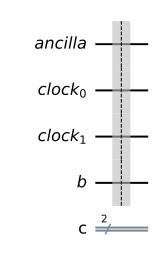

In [80]:
# 第2题
# Create the various registers needed
clock = QuantumRegister(2, name='clock')
input = QuantumRegister(1, name='b')
ancilla = QuantumRegister(1, name='ancilla')
measurement = ClassicalRegister(2, name='c')

# Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla, clock, input, measurement)

circuit.barrier()
circuit.draw(output='mpl')

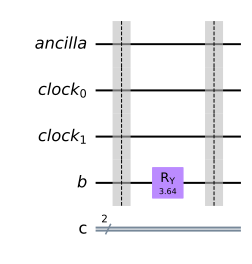

In [81]:
# State preparation. 
# intial_state = [np.sqrt(5)/5,-2* np.sqrt(5)/5]
intial_state = [-0.248865947128923,0.968537939556125]

circuit.ry(2* np.pi - 2*np.arcsin(intial_state[1]), input[0])

circuit.barrier()

# draw the circuit
circuit.draw(output='mpl')

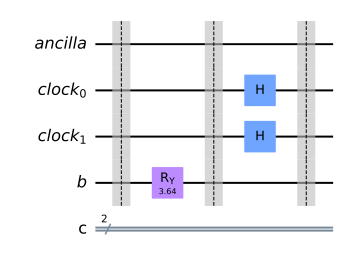

In [82]:
# Perform a Hadamard Transform
circuit.h(clock)

# barrier
circuit.barrier()

# draw the circuit
circuit.draw(output='mpl')

In [83]:
def qft_dagger(circ, q):      

    circ.swap(clock[0], clock[1])
    circ.h(clock[0])
    circ.cu1(-np.pi/2, clock[0], clock[1])
    circ.h(clock[1])
    

def qft(circ, q):
    circ.h(clock[1])
    circ.cu1(np.pi/2, clock[0], clock[1])
    circ.h(clock[0])
    circ.swap(clock[0], clock[1])

In [84]:
def qpe(circ, clock, target):


    # # e^{i*A*t}
    #  4 paras [pi/3, -2.97167419886273 + 5*pi/4, -2.97167419886273 + pi/4, 2.97167419886273]
    circuit.cu(np.pi/3, -2.97167419886273 + 5*np.pi/4, -2.97167419886273 + np.pi/4, 2.97167419886273, clock[0], input, label='U')
    
    # # e^{i*A*t*2}
    # 4 paras [pi/2,0,pi/0]
    circuit.cu(np.pi/2, 0, np.pi, 0, clock[1], input, label='U2')


    circuit.barrier();
    
    # Perform an inverse QFT on the register holding the eigenvalues
    qft_dagger(circuit, clock)
    
def inv_qpe(circ, clock, target):
    
    # Perform a QFT on the register holding the eigenvalues
    qft(circuit, clock)

    circuit.barrier()

    # # e^{i*A*t*2}
    # 4 paras [pi/2,0,pi/0]
    circuit.cu(np.pi/2, 0, np.pi, 0, clock[1], input, label='U2')

    # #circuit.barrier();

    # # e^{i*A*t}
    # 4 paras [pi/3, 2.97167419886273 - 5*pi/4, 2.97167419886273 - pi/4, -2.97167419886273 + 2*pi]
    circuit.cu(np.pi/3, 2.97167419886273 - 5*np.pi/4, 2.97167419886273 - np.pi/4, -2.97167419886273 + 2*np.pi, clock[0], input, label='U')


    circuit.barrier()

/var/folders/q5/bscl3yqx4dlfyz05vjg3cwbr0000gn/T/ipykernel_54503/2334857158.py:5: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  circ.cu1(-np.pi/2, clock[0], clock[1])


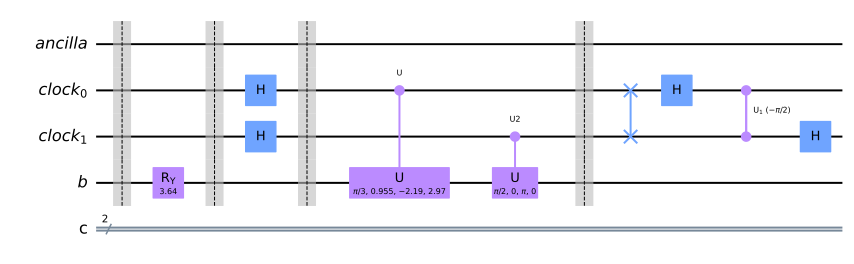

In [85]:
# Perform the QPE
qpe(circuit, clock, input)

# draw the circuit
circuit.draw(output='mpl')

In [86]:
# barrier
circuit.barrier()

# C-RY gates
# This section is to test and implement C = 1
circuit.cry(np.pi, clock[0], ancilla)
circuit.cry(np.pi/3, clock[1], ancilla)

circuit.barrier()

circuit.measure(ancilla, measurement[0])
circuit.barrier()

# Perform the inverse QPE
inv_qpe(circuit, clock, input)

# Perform a Hadamard Transform
circuit.h(clock)

circuit.barrier()


circuit.measure(input, measurement[1])

/var/folders/q5/bscl3yqx4dlfyz05vjg3cwbr0000gn/T/ipykernel_54503/2334857158.py:11: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  circ.cu1(np.pi/2, clock[0], clock[1])


## 总的电路如下：

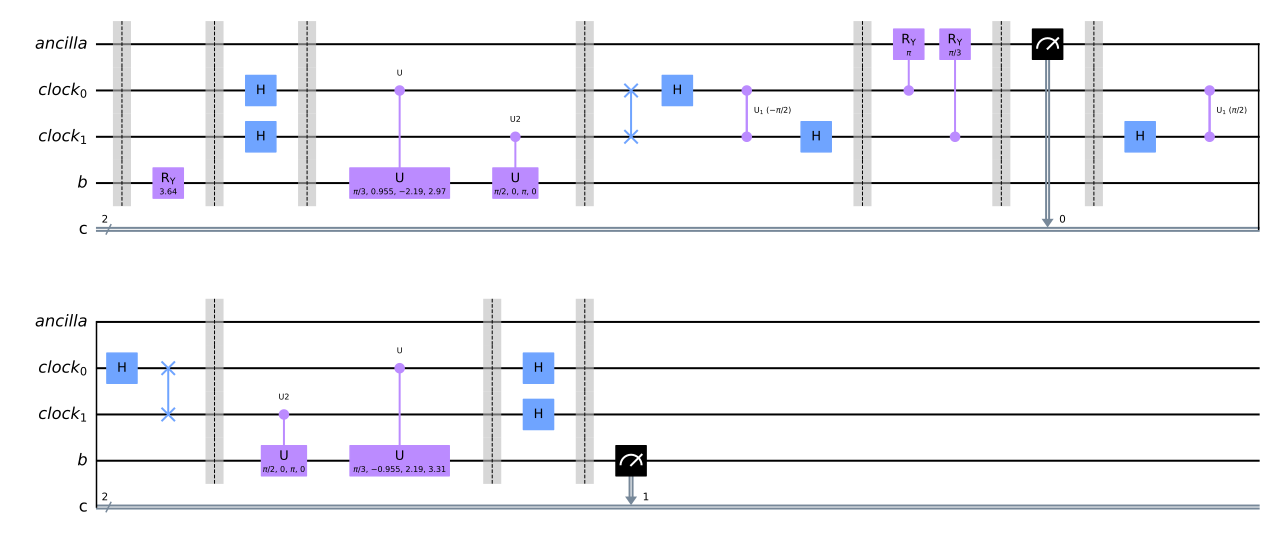

In [87]:
# draw the circuit
circuit.draw(output='mpl')

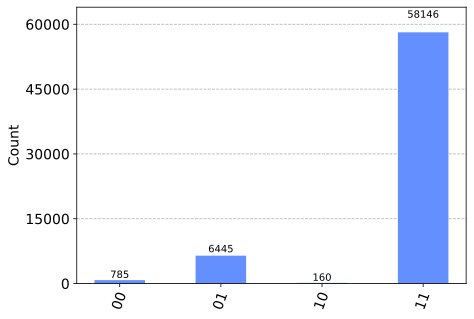

In [89]:
# Execute the circuit using the simulator
simulator = Aer.get_backend('aer_simulator')

job = execute(circuit, backend=simulator, shots=65536)

#Get the result of the execution
result = job.result()

# Get the counts, the frequency of each answer
counts = result.get_counts(circuit)

# Display the results
plot_histogram(counts)